# Recursive showdown—regression

In [1]:
import jax
import optax
import numpy as np
import pandas as pd
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import Callable
from functools import partial

In [2]:
from rebayes.utils import datasets
from rebayes import replay_sgd as rsgd
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi

In [3]:
from jax.flatten_util import ravel_pytree 

In [4]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [76]:
train, test = datasets.load_1d_synthetic_dataset(5_000, 500, sort_data=False)
# train, test = datasets.load_rotated_mnist(frac_train=0.8, num_train=None, target_digit=[1, 2, 3, 4, 5, 6, 7])
# train, test = datasets.load_uci_wine_regression()
# train, test = datasets.load_uci_naval()
# train, test = datasets.load_uci_kin8nm()
# train, test = datasets.load_uci_power()
# train, test = datasets.load_uci_protein()

(X_train, y_train) = train
(X_test, y_test) = test

y_train = y_train.ravel()
y_test = y_test.ravel()

In [77]:
X_train.shape, X_test.shape

((5000, 1), (500, 1))

In [78]:
key = jax.random.PRNGKey(3141)
key_init, key_train = jax.random.split(key)

## The Model

In [79]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x

In [103]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        # x = nn.Dense(50)(x)
        # x = self.activation(x)
        # x = nn.Dense(10)(x)
        # x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x

In [104]:
def rmae_callback(bel, *args, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    yhat = apply_fn(bel.mean, X_test).squeeze()
    err = jnp.abs(y_test - yhat.ravel())
    
    res = {
        "test": err.mean()
    }
    return res

In [ ]:
def callback(eval_fn):
    def pcallback(bel, *args, **kwargs):
        X_test, y_test = kwargs["X_test"], kwargs["y_test"]
        apply_fn = kwargs["apply_fn"]
        metric = eval_fn(apply_fn, bel, X, y)
        res = {
            "test": metric.mean()
        }
        return res
    return pbcallback

## Setup

In [105]:
_, dim_in = X_train.shape
dim_out = 1
learning_rate = 1e-5

In [106]:
@partial(jax.jit, static_argnames=("applyfn",))
def lossfn_fifo(params, counter, X, y, applyfn):
    yhat = applyfn(params, X).ravel()
    loss = (y - yhat) ** 2
    loss = (loss * counter).sum() / counter.sum()
    return loss

In [107]:
model = MLP(dim_out, activation=nn.elu)
batch_init = jnp.ones((1, dim_in))
params_init = model.init(key_init, batch_init)

## The models

In [14]:
%%time
buffer_size = 50
n_inner = 1

state_init = rsgd.FifoTrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(learning_rate),
    buffer_size=buffer_size,
    dim_features=dim_in,
    dim_output=dim_out,
)


rebayes = rsgd.FSGD(lossfn_fifo, n_inner=n_inner)

test = {"X_test": X_test, "y_test": y_test, "apply_fn": model.apply}
state, output_rsg = rebayes.scan(X_train, y_train, bel=state_init, callback=rmae_callback, **test)
acc = output_rsg["test"][-1]
acc

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 1.63 s, sys: 74.7 ms, total: 1.71 s
Wall time: 1.3 s


Array(0.8260958, dtype=float32)

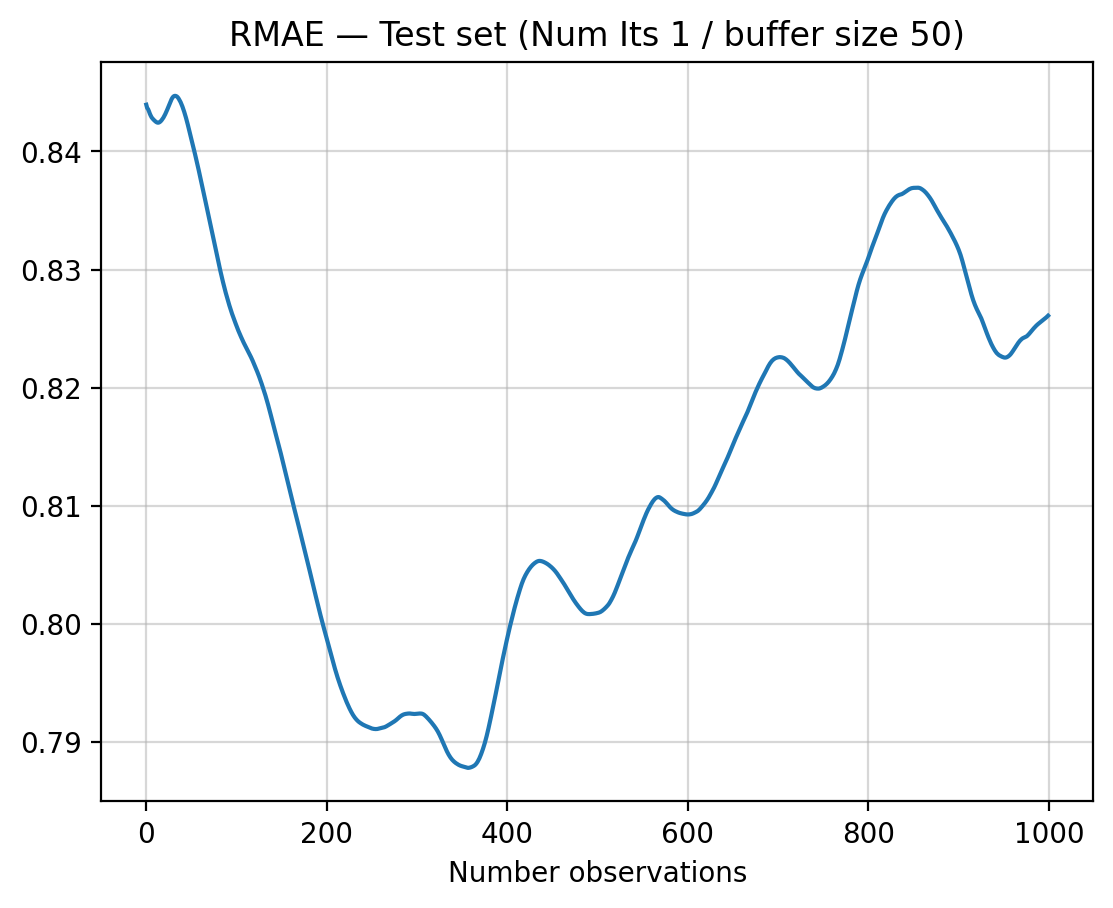

In [15]:
plt.plot(output_rsg["test"])
plt.grid(alpha=0.5)
plt.xlabel("Number observations")
plt.title(f"RMAE — Test set (Num Its {n_inner} / buffer size {buffer_size})");

## ORFit

In [123]:
flat_params, reconstruct_fn = ravel_pytree(params_init)
# Define apply function
def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), x)

apply_fn = partial(apply, model=model, unflatten_fn=reconstruct_fn)

In [17]:
log_init_cov = -2.495
dynamics_weights = 1.0 # 0.95
log_emission_cov = -0.83

params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0
)

params_rebayes = lofi.RebayesParams(
    initial_mean=flat_params,
    initial_covariance=jnp.power(10, log_init_cov).item(),
    dynamics_weights=dynamics_weights,
    dynamics_covariance=1e-5,
    emission_mean_function=apply_fn,
    emission_cov_function=lambda w, x: jnp.power(10, log_emission_cov),
)



estimator_orfit = lofi.RebayesLoFi(params_rebayes, params_lofi, method='orfit')
estimator_lofi = lofi.RebayesLoFi(params_rebayes, params_lofi, method='lofi')
estimator_aov_lofi = lofi.RebayesLoFi(params_rebayes, params_lofi, method='aov_lofi')

test = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}
bel, output_orfit = estimator_orfit.scan(X_train, y_train, callback=rmae_callback, **test)
bel, output_lofi = estimator_lofi.scan(X_train, y_train, callback=rmae_callback, **test)
bel, output_aov_lofi = estimator_aov_lofi.scan(X_train, y_train, callback=rmae_callback, **test)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

## fully-decoupled EKF

In [18]:
log_init_cov = -2.495
dynamics_weights = 1.0
log_emission_cov = -0.83

  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
model_params_linear = lofi.RebayesParams(
    initial_mean=flat_params,
    initial_covariance=jnp.power(10, log_init_cov).item() *  jnp.ones_like(flat_params),
    dynamics_weights=dynamics_weights,
    dynamics_covariance=1e-5,
    emission_mean_function=apply_fn,
    emission_cov_function=lambda w, x: jnp.power(10, log_emission_cov),
)


estimator_fdekf = ekf.RebayesEKF(model_params_linear, method="fdekf")

test = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}
bel, output_fdekf = estimator_fdekf.scan(X_train, y_train, callback=rmae_callback, **test)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Full-covariance EKF

In [39]:
log_init_cov = -2.495
dynamics_weights = 1.0
log_emission_cov = -0.83

n_params = len(flat_params)
Ip = jnp.eye(n_params)

params_rebayes = lofi.RebayesParams(
    initial_mean=flat_params,
    initial_covariance=jnp.power(10, log_init_cov).item() * Ip,
    dynamics_weights=dynamics_weights * Ip,
    dynamics_covariance=1e-5 * Ip,
    emission_mean_function=apply_fn,
    emission_cov_function=lambda w, x: jnp.power(10, log_emission_cov),
)


estimator_fcekf = ekf.RebayesEKF(params_rebayes, method="fcekf")

test = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}
bel, output_fcekf = estimator_fcekf.scan(X_train, y_train, callback=rmae_callback, **test)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Analysing results

In [40]:
data = {
    "rsgd": np.array(output_rsg["test"]),
    "orfit": np.array(output_orfit["test"]),
    "lofi": np.array(output_lofi["test"]),
    "lofi-aov": np.array(output_aov_lofi["test"]),
    "fd-ekf": np.array(output_fdekf["test"]),
    "fc-ekf": np.array(output_fcekf["test"])
}

data = pd.DataFrame(data)

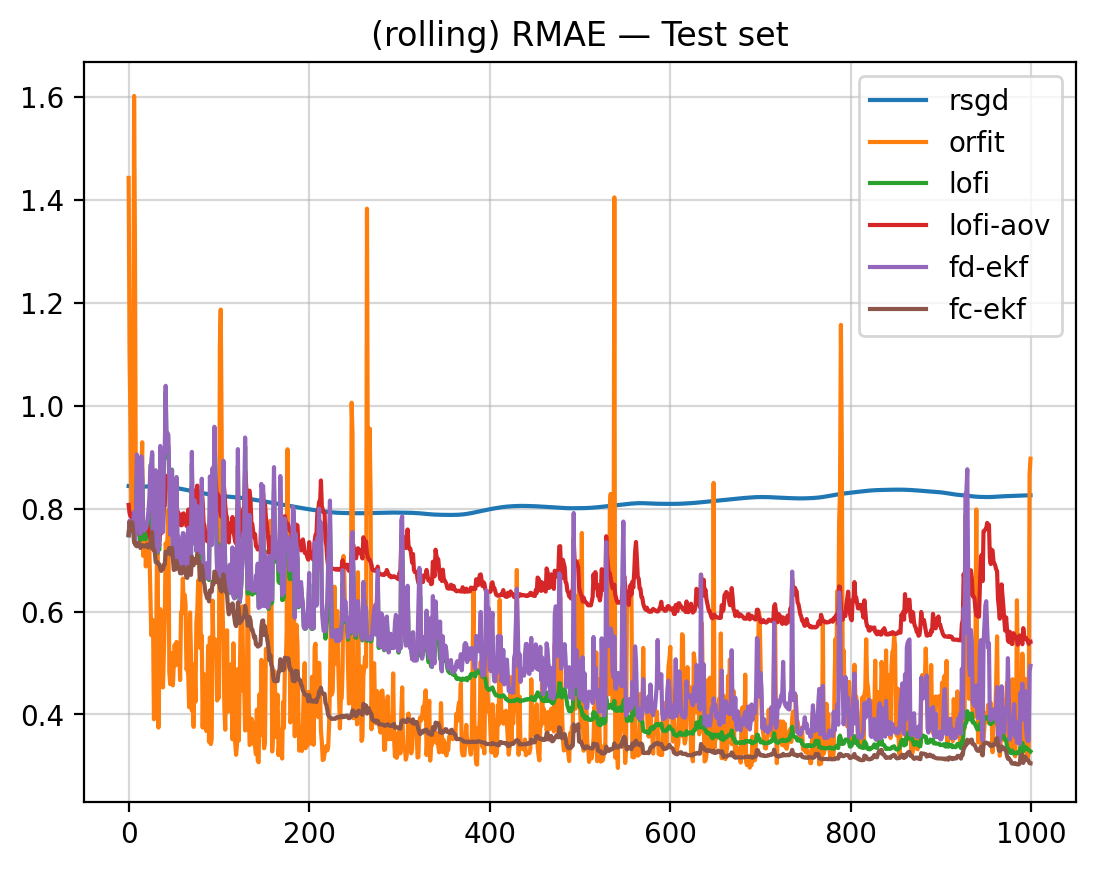

In [41]:
data.plot()
plt.title(f"(rolling) RMAE — Test set");
plt.grid(alpha=0.5)
plt.legend()

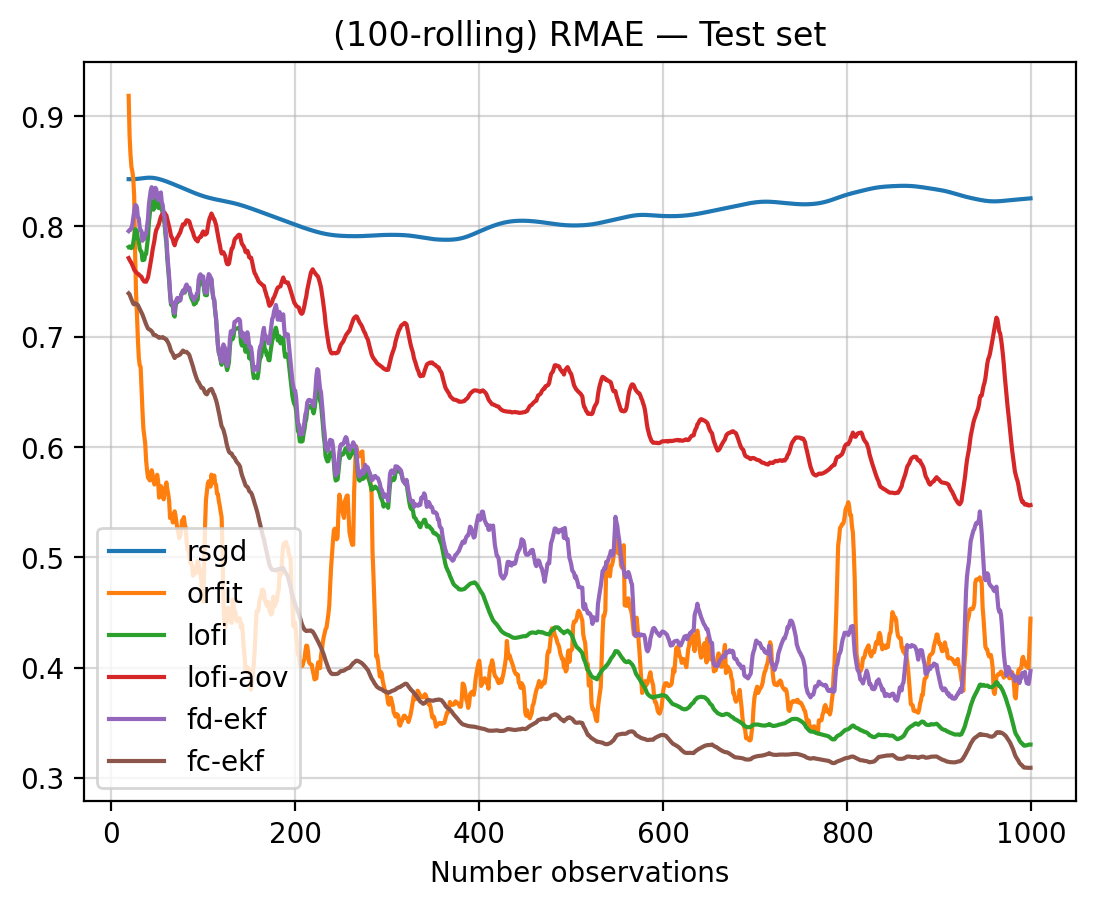

In [43]:
data.drop([], axis=1).rolling(20).mean().plot()
plt.xlabel("Number observations")
plt.title(f"(100-rolling) RMAE — Test set")
# plt.ylim(0.2, 0.4)
plt.grid(alpha=0.5)

---

# BayesOpt test

In [108]:
from bayes_opt import BayesianOptimization

In [109]:
n_warmup = 1000

X_warmup = X_train[:n_warmup]
y_warmup = y_train[:n_warmup]

X_learn = X_train[n_warmup:]
y_learn = y_train[n_warmup:]

In [110]:
flat_params, reconstruct_fn = ravel_pytree(params_init)
# Define apply function
def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), x)

apply_fn = partial(apply, model=model, unflatten_fn=reconstruct_fn)
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

test_warmup = {"X_test": X_warmup[-100:], "y_test": y_warmup[-100:], "apply_fn": apply_fn}

## LoFi

In [111]:
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0
)
    
def bbf(log_init_cov, dynamics_weights, log_emission_cov, log_dynamics_cov):
    params_rebayes = lofi.RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.exp(log_init_cov).item(),
        dynamics_weights=dynamics_weights,
        dynamics_covariance=jnp.exp(log_dynamics_cov),
        emission_mean_function=apply_fn,
        emission_cov_function=lambda w, x: jnp.exp(log_emission_cov),
    )

    estimator = lofi.RebayesLoFi(params_rebayes, params_lofi, method='lofi')

    bel, output = estimator.scan(X_warmup[:-100], y_warmup[:-100], progress_bar=False)
    metric = rmae_callback(bel, **test_warmup)["test"].item()
    return -metric

In [112]:
%%time
pbounds = {
    "log_init_cov": (-5, 1.1),
    "dynamics_weights": (0, 1),
    "log_emission_cov": (-7, -1e-6),
    "log_dynamics_cov": (-7, -1e-6),
}

optimizer = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=314,
)

optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -1.052    | 0.9169    | -2.88     | -5.145    | -0.2224   |
| 2         | -0.8342   | 0.918     | -1.209    | -1.904    | -3.411    |
| 3         | -0.8308   | 0.9118    | -5.175    | -1.635    | -3.405    |
| 4         | -0.8208   | 0.1223    | -4.298    | -1.119    | -3.303    |
| 5         | -0.9552   | 0.06991   | -2.568    | -2.907    | -1.454    |
| 6         | -1.01     | 0.6772    | -2.19     | -3.928    | -3.042    |
| 7         | -0.9997   | 0.5706    | -3.641    | -0.9725   | 0.09231   |
| 8         | -0.9901   | 0.1058    | -6.577    | -2.822    | -0.1664   |
| 9         | -1.0      | 0.2264    | -3.254    | -6.048    | -2.729    |
| 10        | -0.8407   | 0.152     | -3.991    | -1.451    | -2.518    |
| 11        | -0.4758   | 1.0       | -1.899    | -1e-06    | -4.99     |
| 12        | -0.8151   | 0.0       | 

In [113]:
max_params = optimizer.max["params"].copy()

init_cov = np.exp(max_params["log_init_cov"])
emission_cov = np.exp(max_params["log_emission_cov"])
dynamics_cov = np.exp(max_params["log_dynamics_cov"])
dynamics_weights = max_params["dynamics_weights"]

params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0
)


params_rebayes = lofi.RebayesParams(
    initial_mean=flat_params,
    emission_mean_function=apply_fn,
    
    initial_covariance=init_cov,
    emission_cov_function=lambda w, x: emission_cov,
    dynamics_covariance=dynamics_cov,
    dynamics_weights=dynamics_weights
)

estimator = lofi.RebayesLoFi(params_rebayes, params_lofi, method='lofi')

bel, output = estimator.scan(X_learn, y_learn, callback=rmae_callback, progress_bar=False, **test_kwargs)

## ORFit

In [114]:
estimator_orfit = lofi.RebayesLoFi(params_rebayes, params_lofi, method='orfit')
bel, output_orfit = estimator_orfit.scan(X_learn, y_learn, callback=rmae_callback, progress_bar=False, **test_kwargs)

## DecEKF

In [115]:
%%time
def bbf(log_init_cov, dynamics_weights, log_emission_cov, log_dynamics_cov):
    params_rebayes = lofi.RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.exp(log_init_cov).item() * jnp.ones_like(flat_params),
        dynamics_weights=dynamics_weights,
        dynamics_covariance=jnp.exp(log_dynamics_cov),
        emission_mean_function=apply_fn,
        emission_cov_function=lambda w, x: jnp.exp(log_emission_cov),
    )

    estimator = ekf.RebayesEKF(params_rebayes, method="fdekf")

    bel, output = estimator.scan(X_warmup[:-100], y_warmup[:-100], progress_bar=False)
    metric = rmae_callback(bel, **test_warmup)["test"].item()
    return -metric


optimizer = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=314,
)

optimizer.maximize(
    init_points=10,
    n_iter=15,
)




|   iter    |  target   | dynami... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -1.047    | 0.9169    | -2.88     | -5.145    | -0.2224   |
| 2         | -1.062    | 0.918     | -1.209    | -1.904    | -3.411    |
| 3         | -0.8563   | 0.9118    | -5.175    | -1.635    | -3.405    |
| 4         | -0.8163   | 0.1223    | -4.298    | -1.119    | -3.303    |
| 5         | -0.9      | 0.06991   | -2.568    | -2.907    | -1.454    |
| 6         | -1.017    | 0.6772    | -2.19     | -3.928    | -3.042    |
| 7         | -0.829    | 0.5706    | -3.641    | -0.9725   | 0.09231   |
| 8         | -0.8155   | 0.1058    | -6.577    | -2.822    | -0.1664   |
| 9         | -0.9962   | 0.2264    | -3.254    | -6.048    | -2.729    |
| 10        | -0.819    | 0.152     | -3.991    | -1.451    | -2.518    |
| 11        | -0.815    | 0.0       | -6.923    | -1e-06    | -1.16     |
| 12        | -0.8151   | 0.0       | 

In [116]:
max_params = optimizer.max["params"].copy()

init_cov = np.exp(max_params["log_init_cov"])
emission_cov = np.exp(max_params["log_emission_cov"])
dynamics_cov = np.exp(max_params["log_dynamics_cov"])
dynamics_weights = max_params["dynamics_weights"]

params_rebayes = lofi.RebayesParams(
    initial_mean=flat_params,
    emission_mean_function=apply_fn,
    
    initial_covariance=init_cov * jnp.ones_like(flat_params),
    emission_cov_function=lambda w, x: emission_cov,
    dynamics_covariance=dynamics_cov,
    dynamics_weights=dynamics_weights
)

estimator = ekf.RebayesEKF(params_rebayes, method="fdekf")
bel, output_dekf = estimator.scan(X_learn, y_learn, callback=rmae_callback, progress_bar=False, **test_kwargs)

## LoFi — aov

In [117]:
%%time
def bbf(log_init_cov, dynamics_weights, log_emission_cov, log_dynamics_cov):
    params_rebayes = lofi.RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.exp(log_init_cov).item(),
        dynamics_weights=dynamics_weights,
        dynamics_covariance=jnp.exp(log_dynamics_cov),
        emission_mean_function=apply_fn,
        emission_cov_function=lambda w, x: jnp.exp(log_emission_cov),
    )

    estimator = lofi.RebayesLoFi(params_rebayes, params_lofi, method="aov_lofi")
    
    bel, output = estimator.scan(X_warmup[:-100], y_warmup[:-100], progress_bar=False)
    metric = rmae_callback(bel, **test_warmup)["test"].item()
    return -metric


optimizer = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=314,
)

optimizer.maximize(
    init_points=10,
    n_iter=15,
)




|   iter    |  target   | dynami... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -1.035    | 0.9169    | -2.88     | -5.145    | -0.2224   |
| 2         | -0.8159   | 0.918     | -1.209    | -1.904    | -3.411    |
| 3         | -0.8157   | 0.9118    | -5.175    | -1.635    | -3.405    |
| 4         | -0.816    | 0.1223    | -4.298    | -1.119    | -3.303    |
| 5         | -0.8276   | 0.06991   | -2.568    | -2.907    | -1.454    |
| 6         | -0.8202   | 0.6772    | -2.19     | -3.928    | -3.042    |
| 7         | -0.9653   | 0.5706    | -3.641    | -0.9725   | 0.09231   |
| 8         | -0.878    | 0.1058    | -6.577    | -2.822    | -0.1664   |
| 9         | -0.8185   | 0.2264    | -3.254    | -6.048    | -2.729    |
| 10        | -0.8189   | 0.152     | -3.991    | -1.451    | -2.518    |
| 11        | -0.8152   | 0.0       | -4.299    | -3.996    | -4.357    |
| 12        | -0.8151   | 0.0       | 

In [118]:
max_params = optimizer.max["params"].copy()

init_cov = np.exp(max_params["log_init_cov"])
emission_cov = np.exp(max_params["log_emission_cov"])
dynamics_cov = np.exp(max_params["log_dynamics_cov"])
dynamics_weights = max_params["dynamics_weights"]

params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0
)


params_rebayes = lofi.RebayesParams(
    initial_mean=flat_params,
    emission_mean_function=apply_fn,
    
    initial_covariance=init_cov,
    emission_cov_function=lambda w, x: emission_cov,
    dynamics_covariance=dynamics_cov,
    dynamics_weights=dynamics_weights
)

estimator_lofi_aov = lofi.RebayesLoFi(params_rebayes, params_lofi, method="aov_lofi")
bel, output_lofi_aov = estimator_lofi_aov.scan(X_learn, y_learn, callback=rmae_callback, progress_bar=False, **test_kwargs)

## FC-EKF

In [125]:
%%time
def bbf(log_init_cov, dynamics_weights, log_emission_cov, log_dynamics_cov):
    
    num_params = len(flat_params)
    Ip = jnp.eye(num_params)
    params_rebayes = lofi.RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.exp(log_init_cov).item() * Ip,
        dynamics_weights=dynamics_weights * Ip,
        dynamics_covariance=jnp.exp(log_dynamics_cov) * Ip,
        emission_mean_function=apply_fn,
        emission_cov_function=lambda w, x: jnp.exp(log_emission_cov),
    )

    estimator = ekf.RebayesEKF(params_rebayes, method="fcekf")

    bel, output = estimator.scan(X_warmup[:-100], y_warmup[:-100], progress_bar=False)
    metric = rmae_callback(bel, **test_warmup)["test"].item()
    return -metric


optimizer = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=314,
)

optimizer.maximize(
    init_points=10,
    n_iter=15,
)




|   iter    |  target   | dynami... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -1.159    | 0.9169    | -2.88     | -5.145    | -0.2224   |
| 2         | -1.05     | 0.918     | -1.209    | -1.904    | -3.411    |
| 3         | -0.8563   | 0.9118    | -5.175    | -1.635    | -3.405    |
| 4         | -0.8163   | 0.1223    | -4.298    | -1.119    | -3.303    |
| 5         | -0.9      | 0.06991   | -2.568    | -2.907    | -1.454    |
| 6         | -1.017    | 0.6772    | -2.19     | -3.928    | -3.042    |
| 7         | -0.829    | 0.5706    | -3.641    | -0.9725   | 0.09231   |
| 8         | -0.8155   | 0.1058    | -6.577    | -2.822    | -0.1664   |
| 9         | -0.9962   | 0.2264    | -3.254    | -6.048    | -2.729    |
| 10        | -0.819    | 0.152     | -3.991    | -1.451    | -2.518    |
| 11        | -0.815    | 0.0       | -6.646    | -1e-06    | -1.048    |
| 12        | -0.3512   | 1.0       | 

In [126]:
max_params = optimizer.max["params"].copy()

num_params = len(flat_params)
Ip = jnp.eye(num_params)

init_cov = np.exp(max_params["log_init_cov"]) * Ip
emission_cov = np.exp(max_params["log_emission_cov"])
dynamics_cov = np.exp(max_params["log_dynamics_cov"])
dynamics_weights = max_params["dynamics_weights"] * Ip


params_rebayes = lofi.RebayesParams(
    initial_mean=flat_params,
    emission_mean_function=apply_fn,    
    initial_covariance=init_cov * jnp.ones_like(flat_params),
    emission_cov_function=lambda w, x: emission_cov,
    dynamics_covariance=dynamics_cov,
    dynamics_weights=dynamics_weights
)

estimator = ekf.RebayesEKF(params_rebayes, method="fcekf")
bel, output_fcekf = estimator.scan(X_learn, y_learn, callback=rmae_callback, progress_bar=False, **test_kwargs)
output_fcekf = jax.block_until_ready(output_fcekf)

# Plot results

In [127]:
data = {
    "orfit": np.array(output_orfit["test"]),
    "lofi": np.array(output["test"]),
    "lofi-aov": np.array(output_lofi_aov["test"]),
    "dekf": np.array(output_dekf["test"]),
    "fcekf": np.array(output_fcekf["test"])
}

data = pd.DataFrame(data)

(0.2534819096028805, 0.7)

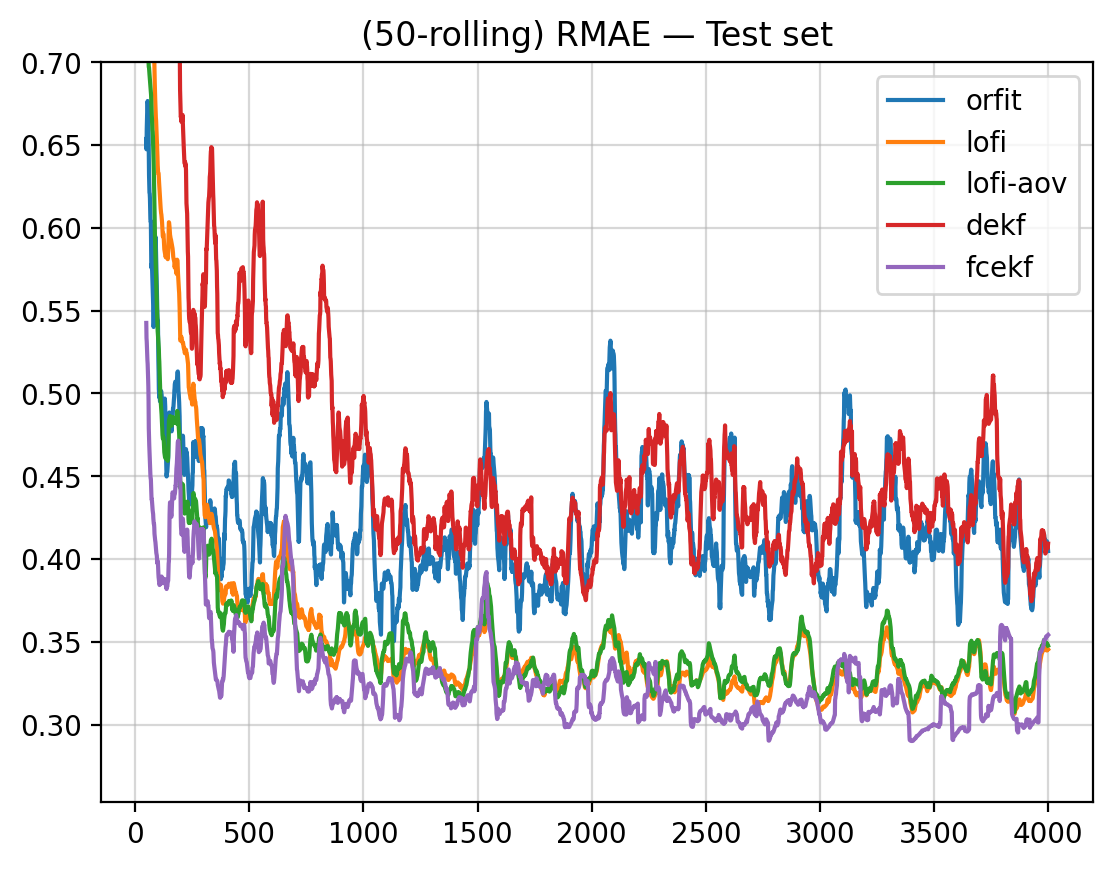

In [135]:
data.rolling(50).mean().plot()
ymin, _ = plt.ylim()
plt.title(f"(50-rolling) RMAE — Test set")
plt.grid(alpha=0.5)
plt.ylim(ymin, 0.7)